# Census Income

In [93]:
# Import libraries
import numpy as np
import pandas as pd
import fairlens as fl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Load in the Census data
df = pd.read_csv("../datasets/adult.csv")
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## Preprocessing

In [2]:
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
45218,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
45219,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
45220,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [3]:
sensitive_attributes = fl.sensitive.detect_names_df(df, deep_search=True)
print(sensitive_attributes)

{'age': 'Age', 'marital-status': 'Family Status', 'race': 'Ethnicity', 'gender': 'Gender', 'relationship': 'Family Status'}


In [4]:
df[["age", "marital-status", "race", "gender", "relationship"]].head()

,age,marital-status,race,gender,relationship
0,25,Never-married,Black,Male,Own-child
1,38,Married-civ-spouse,White,Male,Husband
2,28,Married-civ-spouse,White,Male,Husband
3,44,Married-civ-spouse,Black,Male,Husband
4,34,Never-married,White,Male,Not-in-family


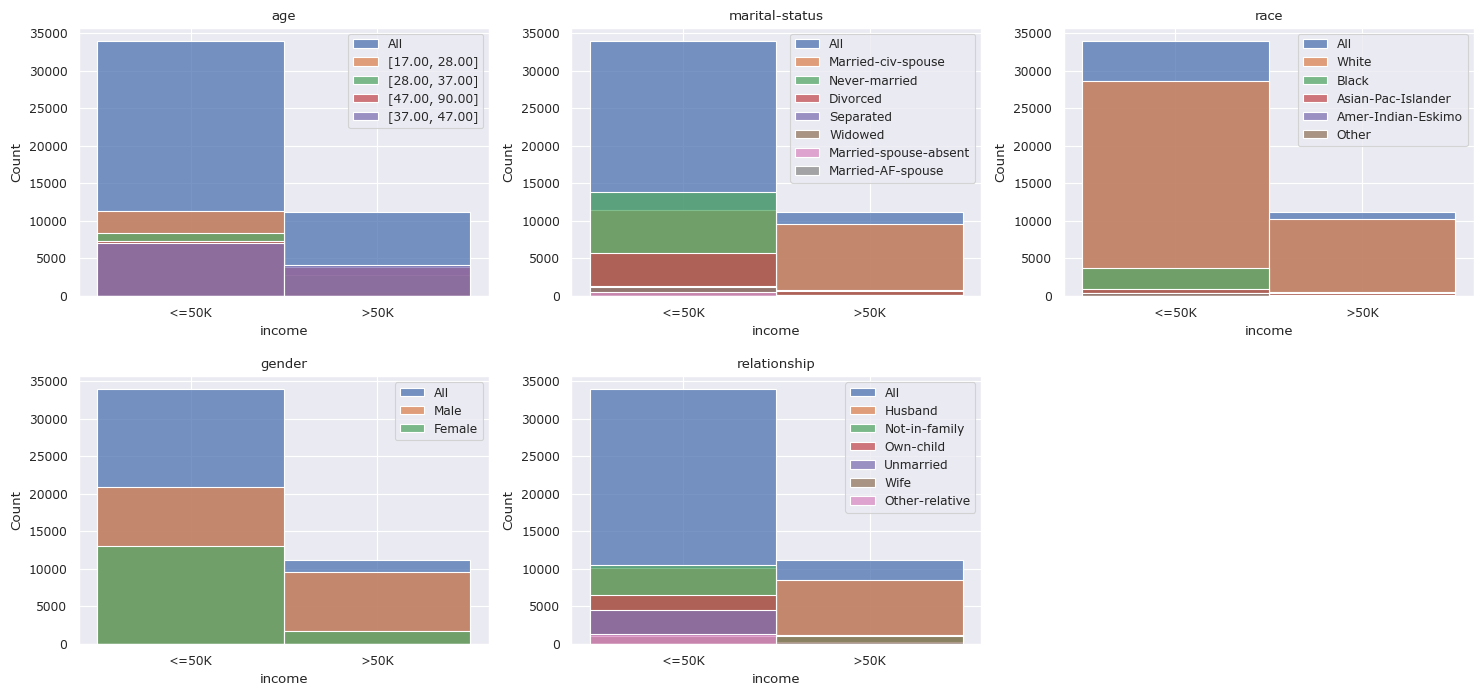

In [5]:
target_attribute = "income"
sensitive_attributes = ["age", "marital-status", "race", "gender", "relationship"]

# Set the seaborn style
fl.plot.use_style()

# Plot the distributions
fl.plot.mult_distr_plot(df, target_attribute, sensitive_attributes, max_quantiles=4)
plt.show()

## Training a Model

Accuracy: 0.999872034397154


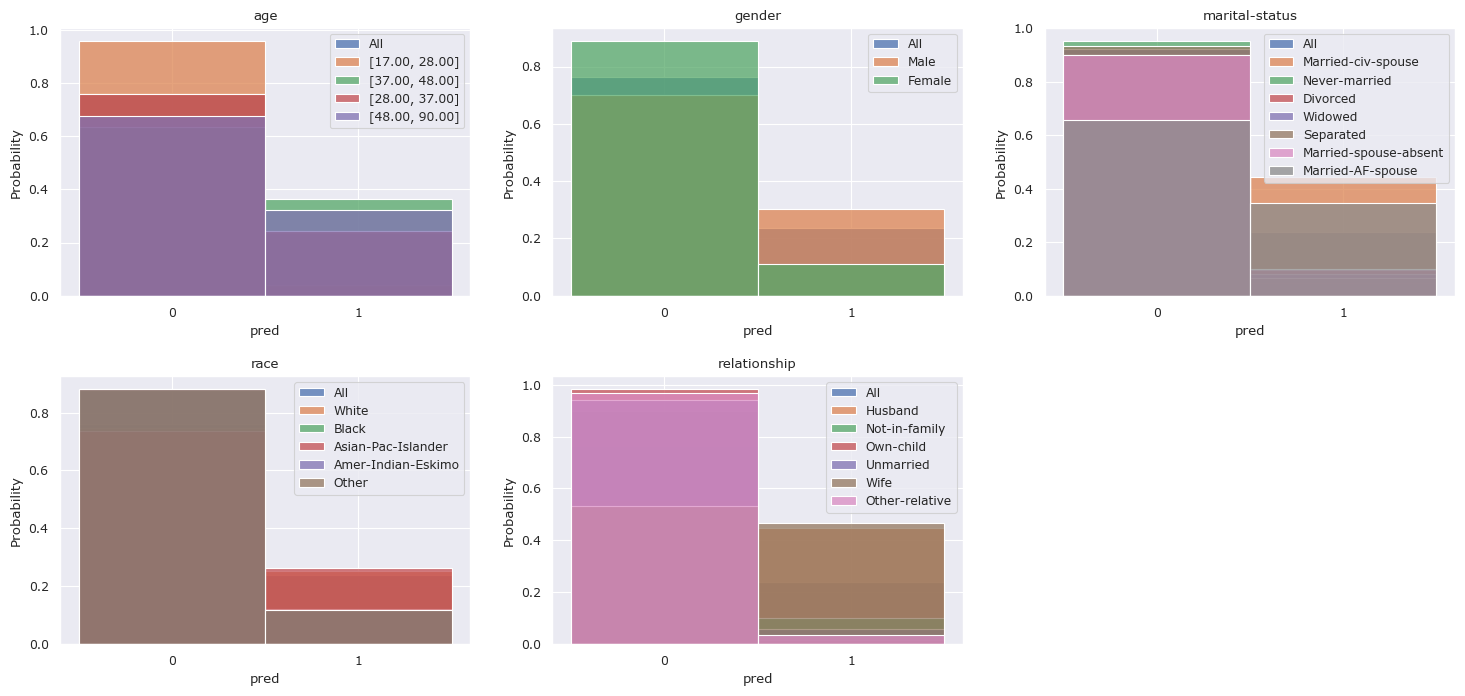

In [95]:
# Select the features to use
df = df[["age", "workclass", "fnlwgt", "educational-num", "marital-status", "occupation", "relationship", 
    "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "income"]]

# Split the dataset into train and test
sp = int(len(df) * 0.8)
df_train = df[:sp].reset_index(drop=True)
df_test = df[sp:].reset_index(drop=True)

# Convert categorical columns to numerical columns
def preprocess(df):
    X = df.copy()

    for col in ["workclass", "marital-status", "occupation", "relationship", "race", "gender"]:
        X[col] = pd.factorize(X[col])[0]

    X.drop(columns=["income"], inplace=True)
    X = X.to_numpy()

    y = df["income"].replace(["<=50K", ">50K"], [0, 1])

    return X, y

X, y = preprocess(df_train)

# Train a classifier
clf = RandomForestClassifier().fit(X, y)

# Classify the training data and print accuracy
y_pred = clf.predict(X)
print(f"Accuracy: {np.mean(y_pred == y)}")

df_train["pred"] = clf.predict(X)

# Plot the distributions
fscorer = fl.FairnessScorer(df_train, "pred", ["age", "marital-status", "race", "gender", "relationship"])
fscorer.plot_distributions(max_quantiles=4, normalize=True)
plt.show()